In [1]:

from matplotlib import pyplot as plt
import numpy as np
from numpy import array
import pandas as pd
import scipy
from scipy.linalg import logm
from scipy.optimize import minimize
import networkx as nx
import seaborn
import itertools
from qiskit.quantum_info import Statevector
from qiskit import *
%matplotlib inline

np.random.seed(42)

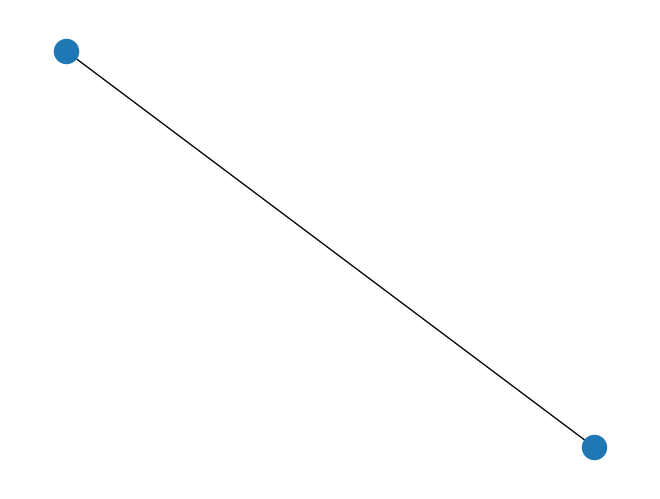

In [2]:
interaction_graph = nx.cycle_graph(2)
nx.draw(interaction_graph)

# VQT
* Definindo o hamiltonaino

In [3]:
ham_matrix = array([[ 0.25,  0,  0,  0  ],
       [ 0, -0.25,  0.5 ,  0],
       [ 0,  0.5, -0.25,  0],
       [ 0,  0,  0,  0.25]])


In [4]:
ham_matrix

array([[ 0.25,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.25,  0.5 ,  0.  ],
       [ 0.  ,  0.5 , -0.25,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.25]])

* Criando o  ansatz

In [4]:
def sigmoid(x):
    return np.exp(x) / (np.exp(x) + 1)

def prob_dist(params):
    return np.vstack([sigmoid(params), 1 - sigmoid(params)]).T

def single_rotation(circuit, phi_params, qubits):
    rotations = ["Z", "Y", "X"]
    for i, rot in enumerate(rotations):
        for qubit in qubits:
            if rot == "Z":
                circuit.rz(phi_params[i][qubit], qubit)
            elif rot == "Y":
                circuit.ry(phi_params[i][qubit], qubit)
            elif rot == "X":
                circuit.rx(phi_params[i][qubit], qubit)

def quantum_circuit(rotation_params, coupling_params, sample=None):
    nr_qubits = 2
    depth = 2
    circuit = QuantumCircuit(nr_qubits)

    if sample is not None:
        for i, bit in enumerate(sample):
            if bit == 1:
                circuit.x(i)

    for i in range(depth):
        single_rotation(circuit, rotation_params[i], range(nr_qubits))
        for j in range(nr_qubits - 1):
            circuit.crx(coupling_params[i][j], j, j + 1)

    return circuit

* Calculando a entropia e defindo função auxíliar para lidar com formato da lista que é passada para o ansatz

In [5]:
def calculate_entropy(distribution):

    total_entropy = 0
    for d in distribution:
        total_entropy += -1 * d[0] * np.log(d[0]) + -1 * d[1] * np.log(d[1])

    # Returns an array of the entropy values of the different initial density matrices

    return total_entropy

def convert_list(params):

    # Separates the list of parameters
    dist_params = params[0:nr_qubits]
    ansatz_params_1 = params[nr_qubits : ((depth + 1) * nr_qubits)]
    ansatz_params_2 = params[((depth + 1) * nr_qubits) :]

    coupling = np.split(ansatz_params_1, depth)

    # Partitions the parameters into multiple lists
    split = np.split(ansatz_params_2, depth)
    rotation = []
    for s in split:
        rotation.append(np.split(s, 3))

    ansatz_params = [rotation, coupling]

    return [dist_params, ansatz_params]

* Cálculo do custo

In [6]:
def exact_cost(params):

    global iterations, beta
    # Transforms the parameter list
    parameters = convert_list(params)
    dist_params = parameters[0]
    ansatz_params = parameters[1]

    # Creates the probability distribution
    distribution = prob_dist(dist_params)

    # Generates a list of all computational basis states of our qubit system
    combos = itertools.product([0, 1], repeat=nr_qubits)
    s = [list(c) for c in combos]

    # Passes each basis state through the variational circuit and multiplies
    # the calculated energy EV with the associated probability from the distribution
    cost = 0
    for i in s:
        qc = quantum_circuit(ansatz_params[0], ansatz_params[1], sample=i)
        state = Statevector.from_instruction(qc)
        result = np.real(state.expectation_value(ham_matrix))
        for j in range(0, len(i)):
            result = result * distribution[j][i[j]]
        cost += result

    # Calculates the entropy and the final cost function
    entropy = calculate_entropy(distribution)
    final_cost = beta* cost - entropy

    final_cost_scalar = final_cost 

    return final_cost_scalar

def cost_execution(params):

    global iterations

    cost = exact_cost(params)

    if iterations % 50 == 0:
        print("Cost at Step {}: {}".format(iterations, cost))

    iterations += 1
    return cost

In [7]:
#Teste
nr_qubits = 2
depth = 2
number = nr_qubits * (1 + depth * 4)
params = [np.random.randint(-300, 300) / 100 for i in range(0, int(number))]
params = np.array(params)
res = convert_list(params)


In [8]:
Temp = np.logspace(np.log10(2),np.log10(1000),100)
Temp

array([   2.        ,    2.12957196,    2.26753836,    2.41444305,
          2.5708651 ,    2.73742111,    2.91476761,    3.10360368,
          3.30467368,    3.5187702 ,    3.74673717,    3.9894732 ,
          4.24793512,    4.52314175,    4.81617791,    5.12819871,
          5.46043407,    5.81419364,    6.19087185,    6.59195354,
          7.0190197 ,    7.47375375,    7.9579482 ,    8.47351165,
          9.02247639,    9.60700635,   10.22940565,   10.89212769,
         11.59778484,   12.34915867,   13.14921099,   14.00109548,
         14.90817014,   15.87401052,   16.90242381,   17.99746387,
         19.16344716,   20.40496983,   21.72692575,   23.13452588,
         24.63331876,   26.2292124 ,   27.92849757,   29.7378726 ,
         31.66446975,   33.71588339,   35.90019986,   38.22602941,
         40.70254011,   43.33949397,   46.14728546,   49.13698248,
         52.32036993,   55.70999626,   59.31922284,   63.1622767 ,
         67.25430655,   71.61144257,   76.2508599 ,   81.19084

* Otimização

In [9]:
#Temp = np.array([0.901,0.905,0.909])
#Temp = np.linspace(1,50,50)
beta_values = 700/Temp
iterations = 0
out_params_dict = {}
for beta in beta_values:
    out = minimize(cost_execution, x0=params, method="COBYLA", options={"maxiter": 1600})
    out_params = out["x"]
    out_params_dict[beta] = out_params

Cost at Step 0: 43.36399982270357
Cost at Step 50: -180.54684380081574
Cost at Step 100: -211.89470850555867
Cost at Step 150: -229.15686208310333
Cost at Step 200: -241.0869667255897
Cost at Step 250: -245.44115556344974
Cost at Step 300: -249.13034102094554
Cost at Step 350: -251.14676224492933
Cost at Step 400: -253.30399871282918
Cost at Step 450: -254.35557387105712
Cost at Step 500: -255.09681118914668
Cost at Step 550: -256.17625996123934
Cost at Step 600: -256.6408681973106
Cost at Step 650: -257.0787518448631
Cost at Step 700: -257.49800867097696
Cost at Step 750: -257.79358046596974
Cost at Step 800: -258.13011307615164
Cost at Step 850: -258.3899908663842
Cost at Step 900: -258.6060806997253
Cost at Step 950: -258.8232282008287
Cost at Step 1000: -258.95819737714754
Cost at Step 1050: -259.0951593184359
Cost at Step 1100: -259.21866769326823
Cost at Step 1150: -259.38070995705124
Cost at Step 1200: -259.5236565413169
Cost at Step 1250: -259.69526552616674
Cost at Step 1300: 

In [11]:
#Preparando estado
def prepare_state(params):

    # Initialies the density matrix

    final_density_matrix = np.zeros((2 ** nr_qubits, 2 ** nr_qubits))

    # Prepares the optimal parameters, creates the distribution and the bitstrings
    parameters = convert_list(params)
    dist_params = parameters[0]
    unitary_params = parameters[1]

    distribution = prob_dist(dist_params)

    combos = itertools.product([0, 1], repeat=nr_qubits)
    s = [list(c) for c in combos]

    # Runs the circuit in the case of the optimal parameters, for each bitstring,
    # and adds the result to the final density matrix

    for i in s:
        qc = quantum_circuit(unitary_params[0], unitary_params[1], sample=i)
        state = Statevector.from_instruction(qc)
        state_vector = state.data
        for j in range(0, len(i)):
            state = np.sqrt(distribution[j][i[j]]) * state
        final_density_matrix = np.add(final_density_matrix, np.outer(state, np.conj(state)))

    return final_density_matrix

# Prepares the density matri

density_matrix_dict = {}

for beta, out_params in out_params_dict.items():
    # Calcula a matriz densidade para cada valor de beta usando os out_params correspondentes
    prep_density_matrix = prepare_state(out_params)
    prep_density_matrix  = np.real(prep_density_matrix )

    # Armazena a matriz densidade no dicionário usando o valor de beta como chave

    density_matrix_dict[beta] = prep_density_matrix

## Cálculo das propriedades termodinâmicas

In [12]:
#Filtro do elemento a11 das matrizes e susceptibilidade 
S = []
Chi = []
A   = [] 
for beta, density_matrix in density_matrix_dict.items():
    #Entropia
    rho = np.real(density_matrix_dict[beta])
    s = -np.trace(rho@logm(rho))
    S.append(s)
    #Susceptibilidade 
    a_11 = density_matrix[0, 0] 
    A.append(a_11)
    chi = 4*a_11
    Chi.append(chi)